# En Code: les auto-encodeurs

## Importation des bibliothèques

Dans cette cellule, nous importons toutes les bibliothèques nécessaires pour notre projet d'auto-encodeur:

- **PyTorch**: pour la création et l'entraînement du réseau de neurones (torch, nn, optim)
- **DataLoader**: pour charger et traiter les données par lots
- **torchvision**: pour accéder au dataset MNIST et aux transformations d'images
- **NumPy**: pour les opérations numériques
- **Matplotlib**: pour visualiser les images et les résultats
- **tqdm**: pour afficher une barre de progression pendant l'entraînement
- **IPython.display et ipywidgets**: pour l'affichage interactif dans le notebook


In [ ]:
import importlib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import tqdm.notebook
from IPython.display import display
import ipywidgets as widgets

## Construire l'auto-encodeur

### Définition de l'encodeur convolutif

Cette cellule définit la classe `ConvEncoder`, qui représente la partie encodeur de notre auto-encodeur. L'encodeur est responsable de compresser l'image d'entrée en une représentation latente de dimension réduite.

Caractéristiques principales:
- Architecture basée sur des couches convolutives (CNN)
- Réduction progressive de la dimension spatiale avec stride=2
- Normalisation par lots (BatchNorm) pour stabiliser l'apprentissage
- Activation LeakyReLU pour introduire de la non-linéarité
- Calcul automatique des dimensions intermédiaires avec un tenseur factice
- Couche finale fully-connected pour projeter vers l'espace latent

Le réseau prend une image en entrée et produit un vecteur latent compact qui capture les caractéristiques essentielles de l'image.


In [ ]:

class ConvEncoder(nn.Module):

    def __init__(
            self,
            input_channels=1,  # 1 for grayscale (MNIST), 3 for RGB
            input_size=28,     # Input image size (28 for MNIST)
            hidden_channels=None,  # Number of channels in hidden layers
            latent_dim=10,
    ):
        super(ConvEncoder, self).__init__()

        if hidden_channels is None:
            hidden_channels = [32, 64, 128]
        # end if

        self.input_channels = input_channels
        self.input_size = input_size
        self.latent_dim = latent_dim
        self.hidden_channels = hidden_channels

        # Build encoder convolutional layers
        encoder_layers = []
        in_channels = input_channels

        for out_channels in hidden_channels:
            encoder_layers.extend([
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2, inplace=True)
            ])
            in_channels = out_channels
        # end for

        self.encoder_conv = nn.Sequential(*encoder_layers)

        # Create a dummy input to calculate the flattened dimension
        with torch.no_grad():
            dummy_input = torch.zeros(1, input_channels, input_size, input_size)
            dummy_output = self.encoder_conv(dummy_input)
            _, C, H, W = dummy_output.shape
            flattened_dim = C * H * W
        # end with

        # Fully connected layers for latent space
        self.encoder_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_dim, latent_dim)
        )

        # Store dimensions for reshaping in decoder
        self.feature_channels = C
        self.feature_height = H
        self.feature_width = W
    # end __init__

    def forward(self, x):
        # Apply convolutional layers
        x = self.encoder_conv(x)

        # Flatten and project to latent space
        latent = self.encoder_fc(x)

        return latent
    # end forward

# end ConvEncoder


### Fonction utilitaire et définition du décodeur convolutif

Cette cellule contient deux éléments importants:

1. **Fonction `load_class`**: Une fonction utilitaire qui permet de charger dynamiquement une classe à partir de son chemin complet. Elle sera utilisée pour charger la fonction d'activation de sortie du décodeur.

2. **Classe `ConvDecoder`**: Le décodeur de notre auto-encodeur, qui est responsable de reconstruire l'image originale à partir de la représentation latente.

Caractéristiques principales du décodeur:
- Commence par une couche fully-connected pour projeter le vecteur latent vers un tenseur 3D
- Utilise des couches de convolution transposée (ConvTranspose2d) pour augmenter progressivement la résolution
- Structure symétrique à l'encodeur, avec les canaux en ordre inverse
- Fonction d'activation configurable en sortie (par défaut Sigmoid)
- Possibilité de recadrer l'image reconstruite aux dimensions cibles

Le décodeur effectue l'opération inverse de l'encodeur, transformant un vecteur latent compact en une image reconstruite.


In [ ]:
def load_class(full_class_path):
    module_name, class_name = full_class_path.rsplit(".", 1)
    module = importlib.import_module(module_name)
    return getattr(module, class_name)
# end load_class


class ConvDecoder(nn.Module):

    def __init__(
            self,
            input_channels=1,  # 1 for grayscale (MNIST), 3 for RGB
            hidden_channels=[32, 64, 128],  # Number of channels in hidden layers
            latent_dim=10,
            feature_channels=128,
            feature_height=4,
            feature_width=4,
            output_activation: str = "torch.nn.Sigmoid",
    ):
        super(ConvDecoder, self).__init__()

        self.input_channels = input_channels
        self.latent_dim = latent_dim
        self.hidden_channels = hidden_channels
        self.feature_channels = feature_channels
        self.feature_height = feature_height
        self.feature_width = feature_width

        flattened_dim = feature_channels * feature_height * feature_width

        # Fully connected layers from latent space
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, flattened_dim),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Build decoder convolutional layers
        decoder_layers = []
        in_channels = hidden_channels[-1]

        # Reverse the hidden channels for the decoder
        for out_channels in reversed(hidden_channels[:-1]):
            decoder_layers.extend([
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2, inplace=True)
            ])
            in_channels = out_channels
        # end for

        # Final layer to output the reconstructed image
        decoder_layers.extend([
            nn.ConvTranspose2d(in_channels, input_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
        ])

        # Add output activation
        activation_cls = load_class(output_activation)
        decoder_layers.append(activation_cls())

        self.decoder_conv = nn.Sequential(*decoder_layers)
    # end __init__

    def forward(self, z, target_height=None, target_width=None):
        # Project from latent space and reshape
        batch_size = z.size(0)
        x = self.decoder_fc(z)
        x = x.view(batch_size, self.feature_channels, self.feature_height, self.feature_width)

        # Apply transposed convolutional layers
        reconstruction = self.decoder_conv(x)

        # Crop to match target dimensions if provided
        if target_height is not None and target_width is not None:
            if reconstruction.size(2) != target_height or reconstruction.size(3) != target_width:
                # Calculate cropping boundaries
                h_diff = reconstruction.size(2) - target_height
                w_diff = reconstruction.size(3) - target_width
                
                # Ensure we can crop (output must be larger than target)
                if h_diff >= 0 and w_diff >= 0:
                    h_start = h_diff // 2
                    w_start = w_diff // 2
                    
                    # Crop the reconstruction to match target dimensions
                    reconstruction = reconstruction[:, :, h_start:h_start + target_height, w_start:w_start + target_width]
                # end if
            # end if
        # end if

        return reconstruction
    # end forward

# end ConvDecoder

### Assemblage de l'auto-encodeur complet

Cette cellule définit la classe `ConvAutoEncoder`, qui combine l'encodeur et le décodeur pour former l'architecture complète de l'auto-encodeur. Cette classe sert de point d'entrée principal pour l'utilisation du modèle.

Caractéristiques principales:
- Intègre les classes `ConvEncoder` et `ConvDecoder` définies précédemment
- Gère automatiquement la transmission des paramètres entre l'encodeur et le décodeur
- Mémorise les dimensions de l'image d'entrée pour assurer une reconstruction aux bonnes dimensions
- Fournit des méthodes pratiques pour encoder et décoder séparément
- Retourne à la fois la reconstruction et la représentation latente lors de l'appel forward

Cette architecture permet d'encoder une image en un vecteur latent compact, puis de reconstruire l'image à partir de ce vecteur, tout en maintenant les dimensions originales.


In [ ]:
class ConvAutoEncoder(nn.Module):

    def __init__(
            self,
            input_channels=1,  # 1 for grayscale (MNIST), 3 for RGB
            input_size=28,     # Input image size (28 for MNIST)
            hidden_channels=[32, 64, 128],  # Number of channels in hidden layers
            latent_dim=10,
            output_activation: str = "torch.nn.Sigmoid",
    ):
        super(ConvAutoEncoder, self).__init__()

        self.input_channels = input_channels
        self.input_size = input_size
        self.latent_dim = latent_dim
        self.hidden_channels = hidden_channels

        # Create the encoder
        self.encoder = ConvEncoder(
            input_channels=input_channels,
            input_size=input_size,
            hidden_channels=hidden_channels,
            latent_dim=latent_dim
        )

        # Create the decoder
        self.decoder = ConvDecoder(
            input_channels=input_channels,
            hidden_channels=hidden_channels,
            latent_dim=latent_dim,
            feature_channels=self.encoder.feature_channels,
            feature_height=self.encoder.feature_height,
            feature_width=self.encoder.feature_width,
            output_activation=output_activation
        )
    # end __init__

    def forward(self, x):
        # Store original input shape for later cropping
        self.original_height = x.size(2)
        self.original_width = x.size(3)
        
        # Encode
        latent = self.encode(x)
        
        # Decode with target dimensions matching the input
        reconstruction = self.decode(latent, target_height=self.original_height, target_width=self.original_width)

        return reconstruction, latent
    # end __forward__

    def encode(self, x):
        return self.encoder(x)
    # end encode

    def decode(self, z, target_height=None, target_width=None):
        # Use stored original dimensions if available and no target dimensions provided
        if target_height is None and hasattr(self, 'original_height'):
            target_height = self.original_height
        # end if
        
        if target_width is None and hasattr(self, 'original_width'):
            target_width = self.original_width
        # end if
        
        return self.decoder(z, target_height=target_height, target_width=target_width)
    # end decode

# end ConvAutoEncoder

## Le dataset MNIST

### Configuration du matériel d'exécution

Cette cellule configure l'utilisation du GPU via CUDA si disponible. PyTorch peut exécuter les calculs sur CPU ou GPU, et cette configuration permet de détecter automatiquement si un GPU compatible CUDA est disponible sur le système.

- Si un GPU est disponible, les calculs seront effectués sur celui-ci, ce qui accélère considérablement l'entraînement
- Sinon, les calculs seront effectués sur le CPU

La variable `device` sera utilisée tout au long du notebook pour déplacer les tenseurs et les modèles vers le bon périphérique de calcul.


In [ ]:
# CUDA setup
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

### Chargement et préparation des données MNIST

Cette cellule configure et charge le jeu de données MNIST, qui contient des images de chiffres manuscrits (0-9) en niveaux de gris de taille 28x28 pixels.

Étapes principales:
- Définition de la taille des lots (batch_size) à 512 images
- Configuration d'une transformation simple pour convertir les images en tenseurs PyTorch
- Téléchargement et chargement des ensembles d'entraînement (60 000 images) et de test (10 000 images)
- Création des DataLoaders pour l'entraînement et l'évaluation avec:
  - Mélange des données d'entraînement pour éviter les biais d'ordre
  - Chargement parallèle avec plusieurs workers si un GPU est disponible
  - Pin memory pour accélérer les transferts vers le GPU

Les DataLoaders permettent de traiter les données par lots, ce qui est plus efficace pour l'entraînement et optimise l'utilisation de la mémoire.


In [ ]:
# Set batch size
batch_size = 512

# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Download and load the training data
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# Download and load the test data
test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# Create data loader for training
kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

# Create data loader for testing
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

### Extraction d'échantillons du jeu de données

Cette cellule extrait quelques images du jeu d'entraînement pour les visualiser. Nous sélectionnons les 8 premières images du dataset MNIST pour avoir un aperçu des données sur lesquelles nous allons entraîner notre auto-encodeur.

Chaque élément du dataset MNIST est un tuple contenant:
- L'image du chiffre manuscrit (un tenseur)
- L'étiquette correspondante (un entier entre 0 et 9)


In [ ]:
# Get images from the dataset
n_samples = 8
train_images = list()
for i in range(n_samples):
    train_images.append(train_dataset[i])
# end for

### Visualisation des échantillons MNIST

Cette cellule crée une visualisation des 8 images extraites précédemment. Nous affichons les images en niveaux de gris dans une grille horizontale, avec l'étiquette du chiffre comme titre pour chaque image.

Le code:
- Crée une figure avec 8 sous-graphiques (subplots) alignés horizontalement
- Pour chaque image, affiche le tenseur converti en tableau NumPy
- Ajoute l'étiquette du chiffre comme titre
- Désactive les axes pour une meilleure lisibilité
- Ajuste la mise en page et affiche la figure

Cette visualisation nous permet de vérifier visuellement les données d'entrée avant de commencer l'entraînement.


In [ ]:
n_samples = 8
fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*2, 4))
for ax, img in zip(axes, train_images):
    ax.imshow(img[0][0].numpy())
    ax.set_title(str(img[1]))
    ax.axis('off')
# end for
plt.tight_layout()
plt.show()

## Entraînement

### Fixation des seeds

Cette cellule définit des graines (seeds) fixes pour les générateurs de nombres aléatoires de PyTorch et NumPy. Cette étape est cruciale pour assurer la reproductibilité des résultats.

En fixant ces graines:
- Les initialisations des poids du réseau seront identiques à chaque exécution
- La sélection des mini-lots pendant l'entraînement suivra le même ordre
- Tout comportement aléatoire sera prévisible et reproductible

La valeur 42 est choisie arbitrairement (et est un clin d'œil à "Le Guide du voyageur galactique" où 42 est la réponse à "la grande question sur la vie, l'univers et le reste").


In [ ]:
# Set fixed random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

### Boucle d'entraînement de l'Auto-Encodeur

Dans cette section, nous allons entraîner notre auto-encodeur sur le dataset MNIST. Voici une explication détaillée du code qui suit:

1. **Initialisation du modèle**: Nous créons un auto-encodeur convolutif avec:
   - 1 canal d'entrée (images en niveaux de gris)
   - Taille d'entrée de 28x28 pixels (dimensions des images MNIST)
   - 3 couches cachées avec [32, 64, 128] filtres
   - Un espace latent de dimension 7 (très compressé par rapport aux 784 pixels d'origine)
   - Une fonction d'activation Sigmoid en sortie pour normaliser les valeurs entre 0 et 1

2. **Configuration de l'entraînement**:
   - Fonction de perte: MSE (Mean Squared Error) - mesure la différence entre l'image originale et sa reconstruction
   - Optimiseur: Adam avec un taux d'apprentissage de 0.001 et une régularisation L2 (weight_decay)
   - 50 époques d'entraînement sur l'ensemble du jeu de données

3. **Boucle d'entraînement**:
   - Pour chaque époque et chaque lot (batch) d'images:
     - Transfert des données vers le GPU si disponible
     - Remise à zéro des gradients
     - Passage avant (forward pass) pour obtenir les reconstructions
     - Aplatissement des tenseurs pour le calcul de la perte
     - Calcul de l'erreur de reconstruction (MSE)
     - Rétropropagation du gradient (backward pass)
     - Mise à jour des poids du réseau
     - Affichage de la progression et de la perte courante

Cette boucle d'entraînement permet au modèle d'apprendre progressivement à encoder les images dans un espace latent compact, puis à les reconstruire avec le maximum de fidélité possible.

### Création du modèle d'auto-encodeur

Cette cellule instancie notre modèle d'auto-encodeur convolutif avec les paramètres suivants:

- `input_channels=1`: Les images MNIST sont en niveaux de gris (1 seul canal)
- `input_size=28`: Les images MNIST ont une résolution de 28x28 pixels
- `hidden_channels=[32, 64, 128]`: Architecture avec 3 couches cachées de complexité croissante
- `latent_dim=7`: L'espace latent aura seulement 7 dimensions (forte compression par rapport aux 784 pixels d'origine)
- `output_activation='torch.nn.Sigmoid'`: Activation sigmoid en sortie pour normaliser les valeurs entre 0 et 1

La méthode `.to(device)` déplace le modèle sur le GPU si disponible, sinon il reste sur le CPU.


In [ ]:
model = ConvAutoEncoder(
    input_channels=1,  # MNIST has 1 channel
    input_size=28,     # MNIST images are 28x28
    hidden_channels=[32, 64, 128],
    latent_dim=7,
    output_activation='torch.nn.Sigmoid',
).to(device)

### Affichage de la structure du modèle

Cette cellule affiche un résumé de la structure du modèle d'auto-encodeur que nous venons de créer. En exécutant simplement la variable `model` dans une cellule Jupyter, nous obtenons une représentation textuelle de l'architecture complète.

Cette représentation montre:
- La hiérarchie des modules (ConvAutoEncoder, ConvEncoder, ConvDecoder)
- Les couches qui composent chaque module
- Les paramètres de chaque couche

Cet affichage est utile pour vérifier que le modèle a été correctement configuré avant de commencer l'entraînement.


In [ ]:
model

### Configuration de la fonction de perte et de l'optimiseur

Cette cellule définit deux éléments essentiels pour l'entraînement du modèle:

1. **Fonction de perte (Loss function)**: Nous utilisons l'erreur quadratique moyenne (MSE - Mean Squared Error) qui mesure la différence pixel par pixel entre l'image originale et sa reconstruction. Cette métrique est bien adaptée pour les auto-encodeurs car elle encourage le modèle à reconstruire des images visuellement similaires aux originales.

2. **Optimiseur**: Nous utilisons Adam, un algorithme d'optimisation populaire qui adapte automatiquement les taux d'apprentissage pour chaque paramètre avec:
   - `lr=0.001`: Taux d'apprentissage initial
   - `weight_decay=0.0004`: Régularisation L2 qui aide à prévenir le surapprentissage en pénalisant les grands poids

L'optimiseur Adam combine les avantages de plusieurs techniques d'optimisation et converge généralement plus rapidement que la descente de gradient stochastique classique.


In [ ]:
# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=0.001,
    weight_decay=0.0004
)

In [17]:
epochs = 50
total_steps = epochs * len(train_loader)
pbar = tqdm.notebook.tqdm(total=total_steps, desc="Entraînement", leave=True)

for epoch in range(1, epochs + 1):
    model.train()
    # Iterate through training
    for data_i, (data, _) in enumerate(train_loader):
        data = data.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        recon_batch, _ = model(data)
        
        # Flatten the input if it's not already flattened
        if len(data.shape) > 2:
            data = data.view(data.size(0), -1)
        # end if
        
        # Flatten the output if it's not already flattened
        if len(recon_batch.shape) > 2:
            recon_batch = recon_batch.reshape(recon_batch.size(0), -1)
        # end if

        # Calculate loss
        loss = criterion(recon_batch, data)
        # print(f"Loss: {loss.item()}")
        # pbar.update(1)
        
        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Show loss
        pbar.set_postfix(loss=loss.item())
        pbar.update(1)
    # end for data
# end for epoch
model.eval()

Entraînement:   0%|          | 0/5900 [00:00<?, ?it/s]

## Reconstruction

### Chargement des données de test

Après avoir entraîné notre modèle, nous allons maintenant l'évaluer sur des données de test qu'il n'a jamais vues pendant l'entraînement. Cette cellule:

1. Extrait un lot (batch) d'images du jeu de test en utilisant `next(iter(test_loader))`
2. Sépare les images (`test_images`) et leurs étiquettes (`test_cls`)
3. Déplace les tenseurs vers le GPU si disponible avec `.to(device)`

Ces images de test seront utilisées pour évaluer visuellement la qualité des reconstructions produites par notre auto-encodeur entraîné.


In [ ]:
# Get images from the test dataset
test_data = next(iter(test_loader))
test_images, test_cls = test_data
test_images, test_cls = test_images.to(device), test_cls.to(device)

## Génération des reconstructions

Cette cellule fait passer les images de test à travers notre auto-encodeur entraîné. Le modèle effectue deux opérations:

1. **Encodage**: Compression des images en vecteurs latents de dimension 7
2. **Décodage**: Reconstruction des images à partir de ces vecteurs latents

La fonction `model(test_images)` retourne deux éléments:
- `test_recon`: Les images reconstruites (qui devraient ressembler aux images originales)
- `test_latent`: Les représentations latentes des images (vecteurs de dimension 7)

Ces résultats nous permettront d'évaluer visuellement la qualité de reconstruction et d'explorer l'espace latent.


In [ ]:
# Passe dans l'auto-encodeur
test_recon, test_latent = model(test_images)

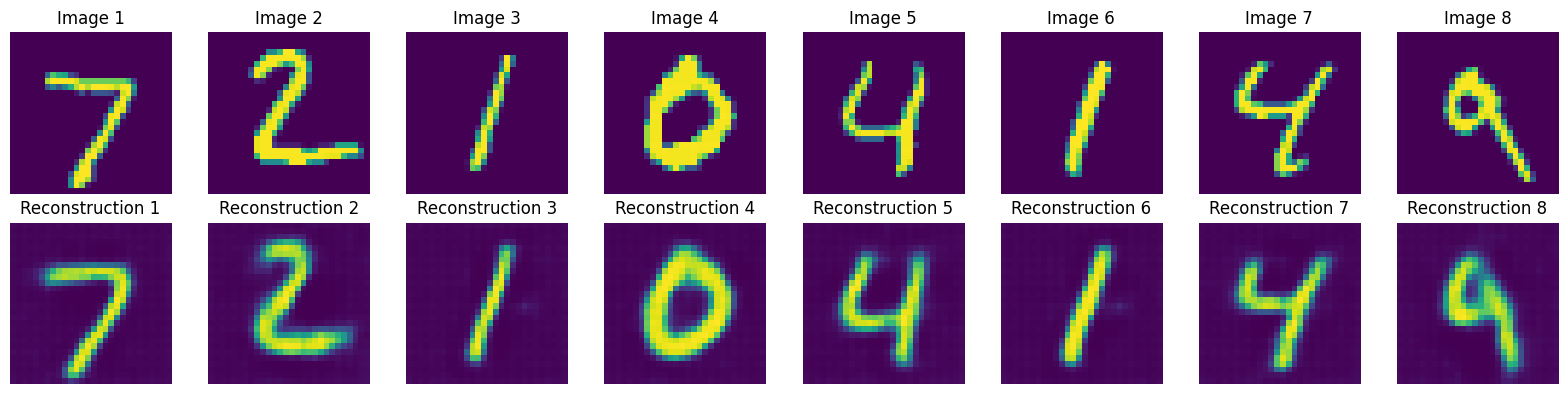

In [45]:
n_samples = 8
fig, axes = plt.subplots(2, n_samples, figsize=(n_samples * 2, 4))
# Row
for ax_i, ax in enumerate(axes):
    # Column
    for ax_j, ay in enumerate(ax):
        if ax_i == 0:
            ay.imshow(test_images[ax_j, 0].cpu().numpy())
            ay.set_title(f"Image {ax_j+1}")
        else:
            ay.imshow(test_recon[ax_j, 0].detach().cpu().numpy())
            ay.set_title(f"Reconstruction {ax_j+1}")
        # end if
        ay.axis('off')
    # end for
# end for
plt.tight_layout()
plt.show()

## Visualiser le latent avec T-SNE

Cette section utilise l'algorithme T-SNE (t-Distributed Stochastic Neighbor Embedding) pour visualiser l'espace latent de notre auto-encodeur en deux dimensions. T-SNE est une technique de réduction de dimensionnalité particulièrement adaptée à la visualisation de données de haute dimension.

Le processus se déroule en plusieurs étapes:

1. **Extraction des représentations latentes**: Nous passons toutes les images du jeu de test dans l'encodeur pour obtenir leurs représentations latentes (vecteurs de dimension 7).

2. **Préparation des données**: Les vecteurs latents et les étiquettes correspondantes (chiffres de 0 à 9) sont collectés et convertis en tableaux NumPy.

3. **Application de T-SNE**: L'algorithme T-SNE réduit les vecteurs latents de dimension 7 à seulement 2 dimensions, tout en préservant au maximum les relations de proximité entre les points.

4. **Visualisation**: Les points 2D sont affichés dans un graphique de dispersion, avec une couleur différente pour chaque chiffre (0-9).

Cette visualisation nous permet d'observer comment l'auto-encodeur organise les différents chiffres dans son espace latent. Si l'entraînement a bien fonctionné, nous devrions voir des clusters distincts pour chaque chiffre, ce qui indique que l'encodeur a appris à séparer les différentes classes dans l'espace latent, même sans supervision explicite.


Cette section utilise l'algorithme T-SNE (t-Distributed Stochastic Neighbor Embedding) pour visualiser l'espace latent de notre auto-encodeur en deux dimensions. T-SNE est une technique de réduction de dimensionnalité particulièrement adaptée à la visualisation de données de haute dimension.

Le processus se déroule en plusieurs étapes:

1. **Extraction des représentations latentes**: Nous passons toutes les images du jeu de test dans l'encodeur pour obtenir leurs représentations latentes (vecteurs de dimension 7).

2. **Préparation des données**: Les vecteurs latents et les étiquettes correspondantes (chiffres de 0 à 9) sont collectés et convertis en tableaux NumPy.

3. **Application de T-SNE**: L'algorithme T-SNE réduit les vecteurs latents de dimension 7 à seulement 2 dimensions, tout en préservant au maximum les relations de proximité entre les points.

4. **Visualisation**: Les points 2D sont affichés dans un graphique de dispersion, avec une couleur différente pour chaque chiffre (0-9).

Cette visualisation nous permet d'observer comment l'auto-encodeur organise les différents chiffres dans son espace latent. Si l'entraînement a bien fonctionné, nous devrions voir des clusters distincts pour chaque chiffre, ce qui indique que l'encodeur a appris à séparer les différentes classes dans l'espace latent, même sans supervision explicite.


### Remarques supplémentaires sur T-SNE

T-SNE est particulièrement utile pour visualiser des données de haute dimension car il préserve les structures locales. Contrairement à d'autres techniques comme PCA (Analyse en Composantes Principales), T-SNE se concentre sur la préservation des distances entre points voisins plutôt que sur la variance globale des données.

Points importants à noter sur T-SNE:

1. **Perplexité**: Ce paramètre contrôle l'équilibre entre la préservation des structures locales et globales. Des valeurs typiques sont entre 5 et 50.

2. **Nature stochastique**: T-SNE utilise une initialisation aléatoire, donc chaque exécution peut produire des visualisations légèrement différentes.

3. **Interprétation**: Dans la visualisation T-SNE, les distances absolues entre clusters éloignés ne sont pas significatives. Seule la présence de clusters distincts est interprétable.

4. **Temps de calcul**: Pour de grands ensembles de données, T-SNE peut être coûteux en calcul. Des alternatives comme UMAP peuvent être considérées.

Dans notre cas, T-SNE nous aide à vérifier si notre auto-encodeur a appris des représentations latentes significatives, où des chiffres similaires sont regroupés ensemble dans l'espace latent.

In [ ]:
# On récupère tous les latents du jeu de test
latents = list()
digits = list()
for data_i, (data, cls) in enumerate(test_loader):
    data = data.to(device)
    
    # Forward pass
    _, latent = model(data)

    # Add batch
    latents.append(latent)
    digits.append(cls)
# end for

# Concat all
latents = torch.cat(latents, dim=0).cpu()
digits = torch.cat(digits, dim=0).cpu()

In [54]:
%pip install scikit-learn

  Using cached joblib-1.5.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 62.5 MB/s eta 0:00:00
Using cached joblib-1.5.1-py3-none-any.whl (307 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.4/35.4 MB 78.8 MB/s eta 0:00:00 MB/s eta 0:00:01:01
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn]0m 3/4 [scikit-learn]
Note: you may need to restart the kernel to use updated packages.


In [56]:
from sklearn.manifold import TSNE

# Convert latents to numpy for t-SNE
latents_np = latents.detach().cpu().numpy()

# Apply t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
latents_2d = tsne.fit_transform(latents_np)

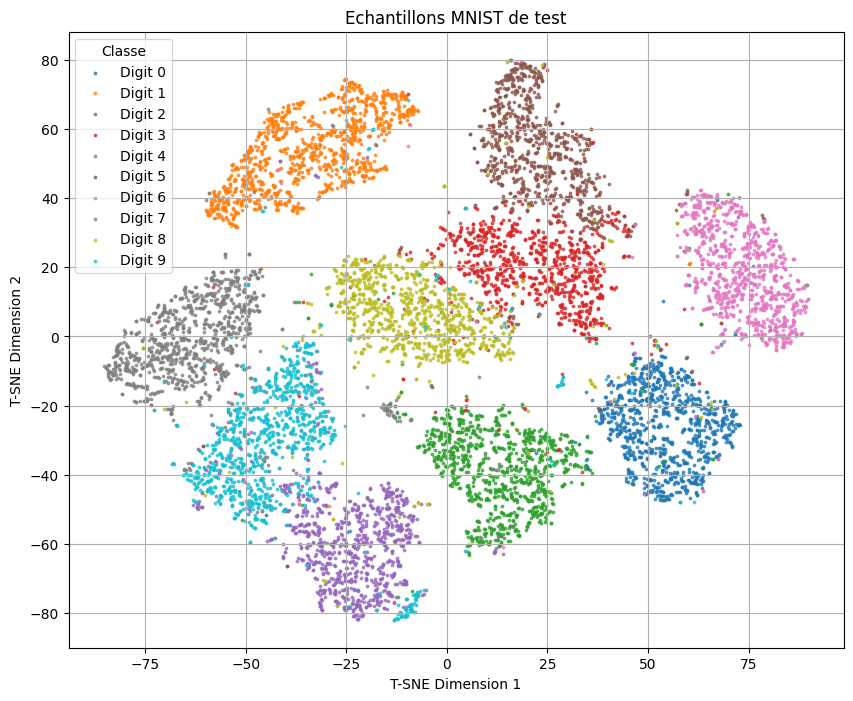

In [77]:
from matplotlib.cm import get_cmap

# Mapping des classes vers des noms
class_names = {idx:f"Digit {idx}" for idx in digits.unique().tolist()}

# Colormap discrète
cmap = plt.get_cmap('tab10')  # jusqu'à 10 classes distinctes
colors = [cmap(i) for i in range(len(class_names))]

plt.figure(figsize=(10, 8))
# plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=digits.numpy(), s=2, alpha=0.6)

# Boucle sur les classes pour tracer chaque groupe
for class_id, class_label in class_names.items():
    idx = digits == class_id
    plt.scatter(
        latents_2d[idx, 0], 
        latents_2d[idx, 1], 
        color=colors[class_id],
        label=class_label,
        alpha=0.7, 
        s=3
    )
# end for

plt.legend(title="Classe")
plt.xlabel("T-SNE Dimension 1")
plt.ylabel("T-SNE Dimension 2")
plt.title("Echantillons MNIST de test")
plt.grid(True)
plt.show()

## Morphing

Cette section démontre une application fascinante des auto-encodeurs: le "morphing" ou l'interpolation entre deux images différentes dans l'espace latent.

Voici comment fonctionne le processus:

1. **Sélection des points de départ et d'arrivée**: Nous sélectionnons aléatoirement deux représentations latentes différentes du jeu de test, correspondant à deux chiffres différents.

2. **Interpolation linéaire**: Nous créons une séquence de 10 points intermédiaires entre ces deux représentations latentes, en utilisant une interpolation linéaire. Pour chaque point intermédiaire, nous calculons:
   ```
   latent_intermédiaire = (1-t) * latent_départ + t * latent_arrivée
   ```
   où t varie de 0 (point de départ) à 1 (point d'arrivée).

3. **Décodage des points intermédiaires**: Chaque point intermédiaire dans l'espace latent est décodé pour générer une image.

4. **Visualisation de la transition**: Les images décodées sont affichées côte à côte, montrant la transformation progressive d'un chiffre à l'autre.

Cette technique illustre la continuité de l'espace latent appris par l'auto-encodeur. Les points intermédiaires dans l'espace latent correspondent à des images qui sont des mélanges plausibles des deux chiffres originaux, montrant comment l'auto-encodeur a appris une représentation continue et significative des données.

### Implémentation du Morphing

Dans le code qui suit, nous allons mettre en pratique le concept de morphing expliqué ci-dessus. Voici les étapes détaillées de l'implémentation:

1. **Sélection aléatoire**: Nous choisissons deux échantillons aléatoires de notre jeu de test, identifiés par `id1` et `id2`. Pour chacun, nous récupérons sa représentation latente (`lat1`, `lat2`) et son chiffre correspondant (`dig1`, `dig2`).

2. **Création des points intermédiaires**: Nous définissons `morphing_size = 10` pour créer 10 points intermédiaires. Nous utilisons `torch.linspace(0, 1, steps=morphing_size)` pour générer une séquence de valeurs t allant de 0 à 1, puis nous calculons l'interpolation linéaire avec la formule:
   ```
   interpolations = (1 - t_values) * lat1 + t_values * lat2
   ```

3. **Décodage et visualisation**: Pour chaque point intermédiaire, nous utilisons le décodeur du modèle pour générer l'image correspondante. Nous affichons ensuite toutes ces images côte à côte, montrant la transition progressive d'un chiffre à l'autre.

Cette implémentation nous permet de visualiser concrètement comment l'auto-encodeur a appris un espace latent continu où l'interpolation entre deux points produit des transitions visuellement cohérentes.


In [ ]:
# Prend deux représentations latentes dans le jeu de test
id1 = np.random.randint(latents.size(0)) + 2
id2 = np.random.randint(latents.size(0)) + 2
lat1, dig1 = latents[id1], digits[id1]
lat2, dig2 = latents[id2], digits[id2]

In [129]:
# Calcule l'interpolation linéaire des latents
morphing_size = 10
t_values = torch.linspace(0, 1, steps=morphing_size).unsqueeze(1)
interpolations = (1 - t_values) * lat1 + t_values * lat2

In [132]:
# Calcule les reconstructions pour chaque latents
lat_rec = list()
for r_i in range(morphing_size):
    lat = interpolations[r_i].to(device).unsqueeze(0)
    rec = model.decode(lat)
    lat_rec.append(rec[0])
# end for
morph_rec = torch.cat(lat_rec, dim=0)

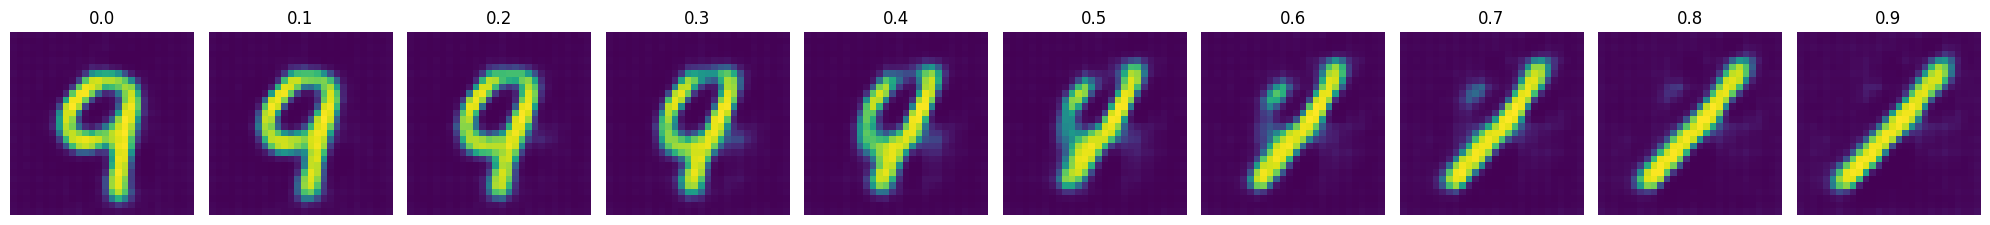

In [134]:
fig, axes = plt.subplots(1, morphing_size, figsize=(morphing_size*2, 4))
for ax_i, ax in enumerate(axes):
    ax.imshow(morph_rec[ax_i].detach().cpu().numpy())
    ax.set_title(f"{ax_i/morphing_size}")
    ax.axis('off')
# end for
plt.tight_layout()
plt.show()